## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

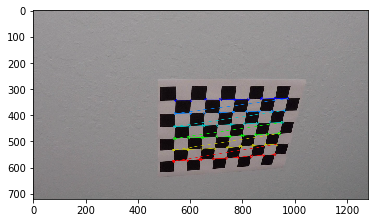

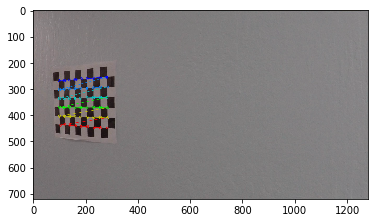

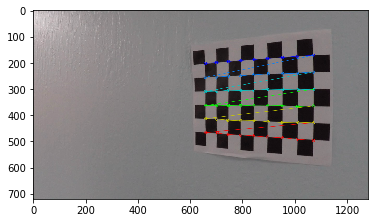

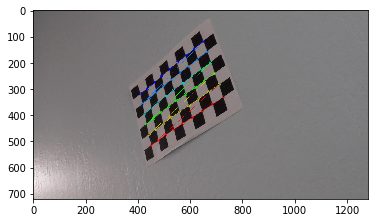

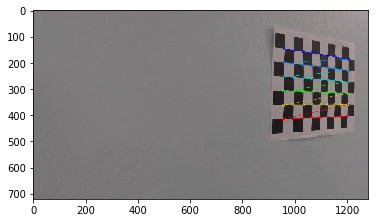

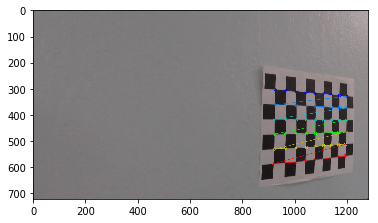

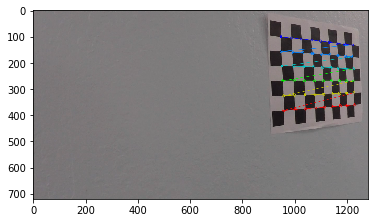

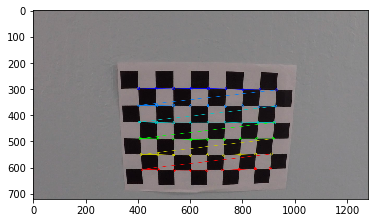

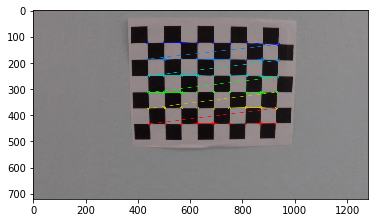

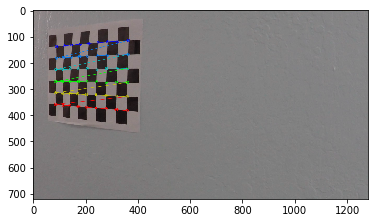

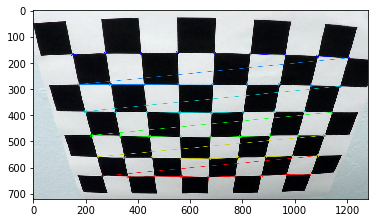

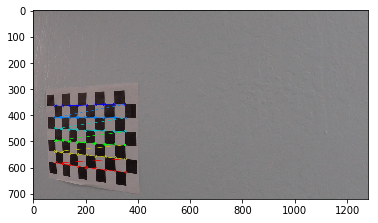

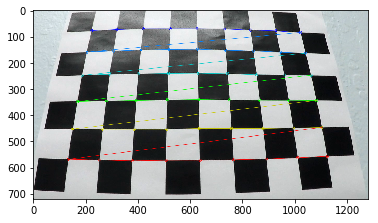

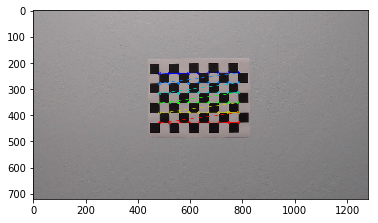

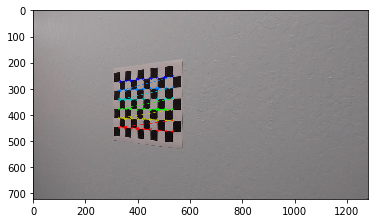

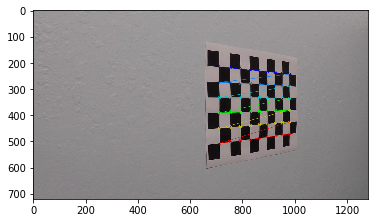

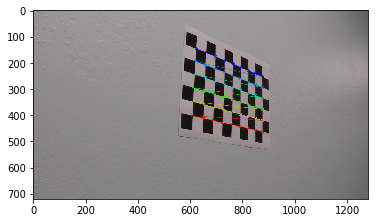

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
        plt.figure()
        plt.imshow(img)
#cv2.destroyAllWindows()

## Apply the distortion correction to the images

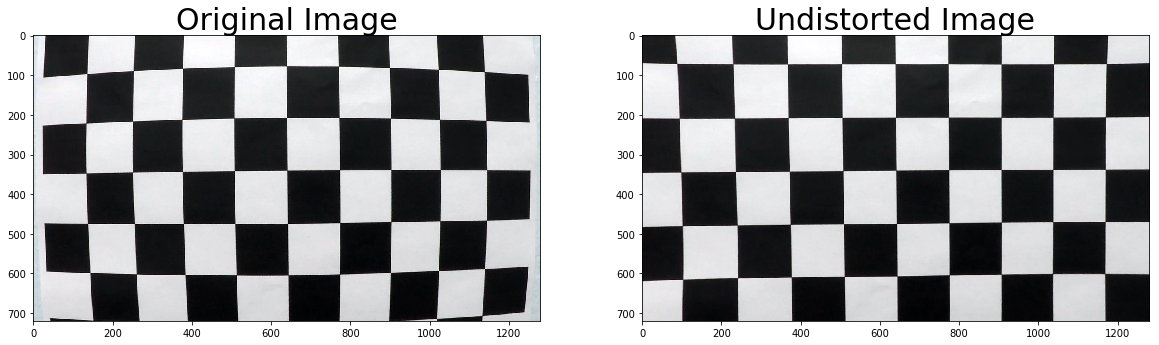

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./examples/calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./examples/calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [3]:
# Undistort the input image
def undistorted(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

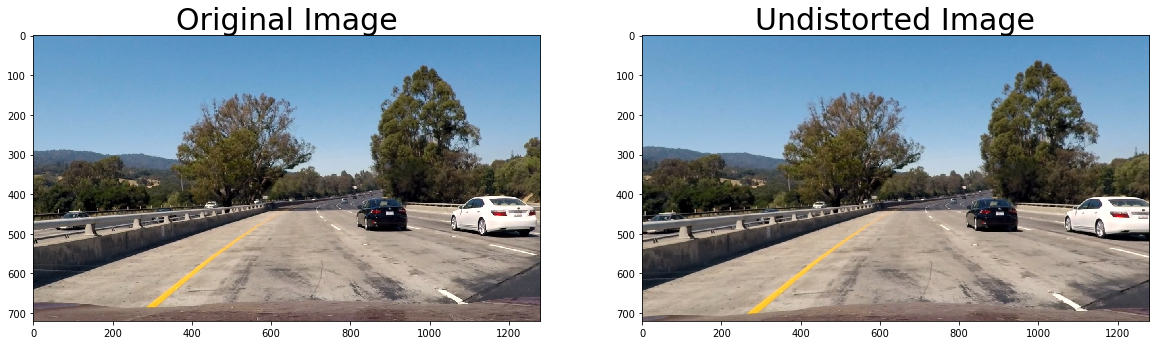

In [8]:
# Show the result of undistorting an image
import matplotlib.image as mpimg
test_image = mpimg.imread('./test_images/test1.jpg')

# Apply the undistorted function
undistorted_image = undistorted(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
## Applying Perpective transform to chessboard
# Camera matrix and distortion coefficients
# accepts image, x and y points
def corners_unwrap(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Convert undistort image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        
        # If we found corners, draw them! 
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        
        offset = 100
        
        img_size = (gray.shape[1], gray.shape[0])
        print(img_size)
        
        # For source points, I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        
        dist = np.float32([offset, offset], 
                          [img_size[0]-offset, offset], 
                          [img_size[0]-offset, img_size[1]-offset], 
                          [offset, img_size[1]-offset])
        
        M = cv2.getPerspectiveTransform(src, dist)
        
        # Wrap the image using OpenCV wrapPerspective()
        wraped = cv2.wrapPerspective(undist, M, img_size)
    return wraped, M

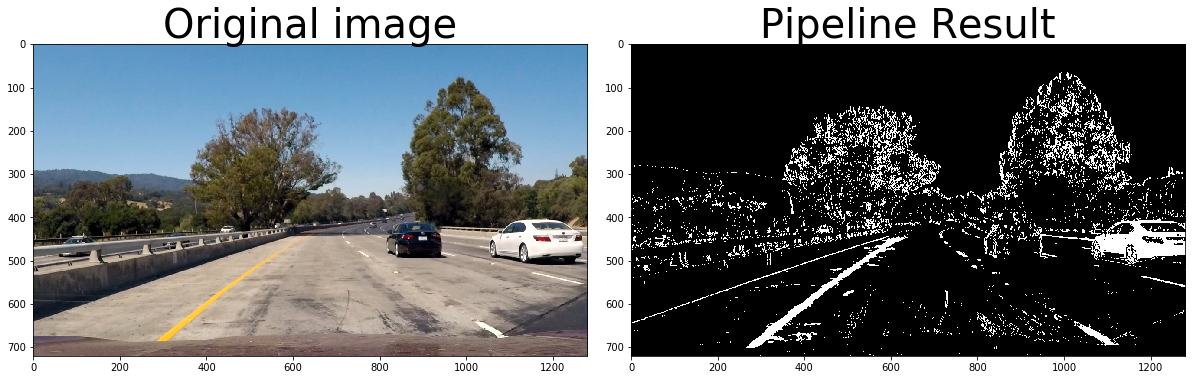

In [36]:
## Color and gradient threshold

def pipeline(img, r_thresh=(210, 255), s_thresh=(120, 255), sx_thresh=(20, 100)):
    
    img = np.copy(img)
    
    R = img[:, :, 0]
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    # Convert to HSV color space and seperate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, r_binary))
    
    combine_binary = np.zeros_like(sxbinary)
    combine_binary[(r_binary == 1) | (sxbinary == 1)] = 1
    return combine_binary

result = pipeline(undistorted_image)

# Plot the result

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()

ax1.imshow(test_image)
ax1.set_title('Original image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)   

In [39]:
## Apply perspective transform
def perspective_transform(image):
    image_shape = (image.shape[1], image.shape[0])
    
    offset = 340
    
    src = np.float32([[[610, 450]],
                      [[680, 450]],
                      [[image_shape[0]-300, 680]],
                      [[380, 680]]
                     ])
    dst = np.float32([[offset, 0],
                      [image_shape[0]-offset, 0],
                      [image_shape[0]-offset, image_shape[1]],
                      [offset, image_shape[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    wraped = cv2.warpPerspective(image, M, image_shape)
    
    return wraped, M

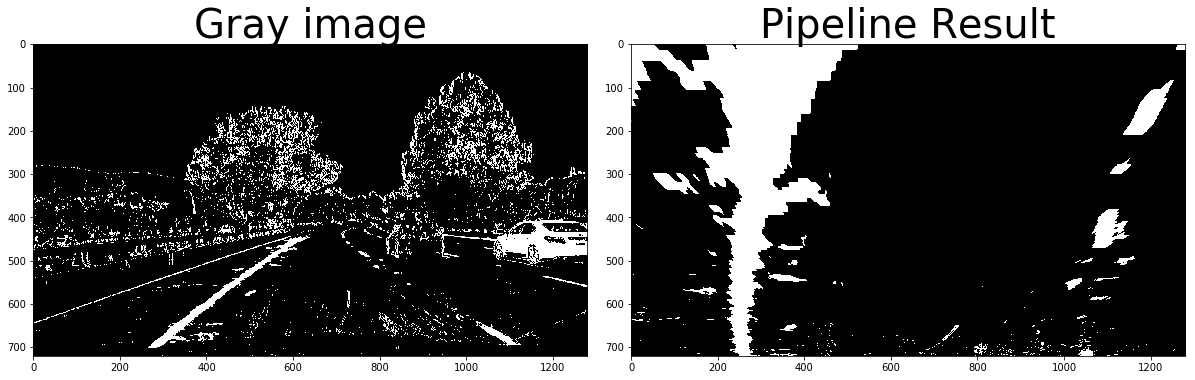

In [42]:
warped, M = perspective_transform(result)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
f.tight_layout()

ax1.imshow(result, cmap='gray')
ax1.set_title('Gray image', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Perspective transform Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)  

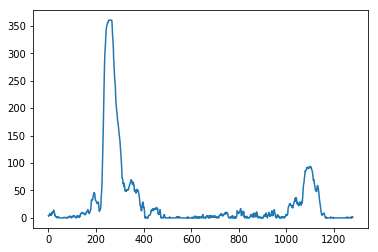

In [45]:
## Detect Lane lines from the perspective transform result
# Find the peaks of the lines in an histogram
histogram = np.sum(warped[warped.shape[0]//2:, :], axis=0)
plt.plot(histogram)

In [50]:
# implement sliding windows for the warped image
out_image = np.dstack((warped, warped, warped)) * 255
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [51]:
# Sliding windows
nwindows = 9

# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)

## Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzerox = np.array(nonzero[1])
nonzeroy = np.array(nonzero[0])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# set the width of the windows +/- margin
margin = 100
minpix = 50

left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_image, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),(0,255, 0), 2)
    cv2.rectangle(out_image, (win_xright_low, win_y_low), (win_xright_high, win_y_high),(0,255, 0), 2)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]   
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]   
    
    # Append these indices to this lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rughtx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

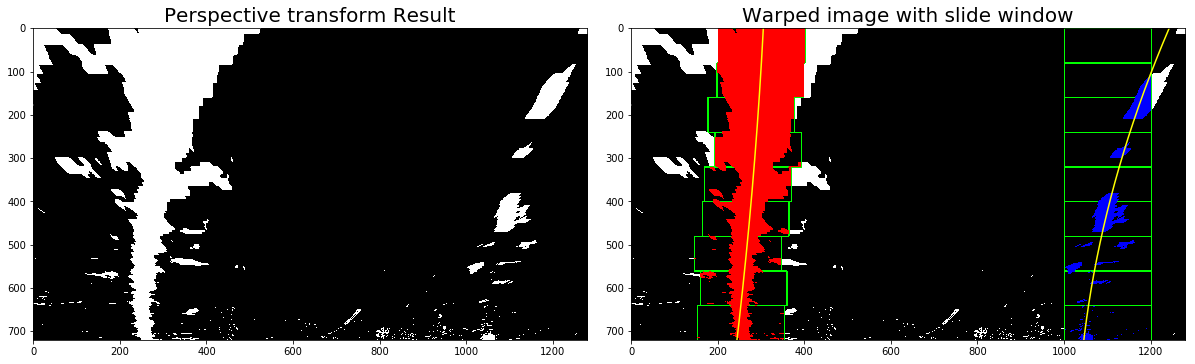

In [56]:
# Plot the x and y values on the wrap image
ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_image[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_image[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
f.tight_layout()

ax1.imshow(warped, cmap='gray')
ax1.set_title('Perspective transform Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

ax2.set_title('Warped image with slide window', fontsize=20)
ax2.imshow(out_image)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
#ax1.xlim(0, 1280)
#ax1.ylim(720, 0)

